# Computing limits on unseen companion masses for KOI-1.01
In this notebook we'll use the `ttv2fast2furious.companion_limits` 
to derive upper limits on the mass of potential companions to KOI-1.01 
based on its lack of TTVs. We'll begin with importing some packages.

In [1]:
import ttv2fast2furious
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from ttv2fast2furious.companion_limits import UnseenPerturberMassUpperLimit
from ttv2fast2furious.companion_limits import PerturberPeriodPhaseToBestSigmaChiSquared
from ttv2fast2furious.kepler import KOISystemObservations

## KOI-1.01's transit timing residuals
We use `KOISystemObservations` to get transit observations for the KOI-1 system which hosts a single detected transiting planet, KOI-1.01. Plotting KOI-1.01's transit time residuals, no TTV signal is evident.

In [3]:
transit_times_data = KOISystemObservations(1)

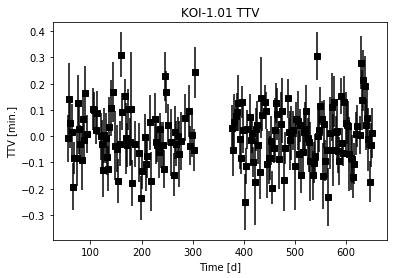

In [65]:
observations = transit_times_data['KOI-1.01']
ttv = observations.linear_fit_residuals()
times = observations.times
err = observations.uncertainties
to_minutes = lambda x: 24*60*x
plt.errorbar(times,to_minutes(ttv),yerr=to_minutes(err),fmt='ks')
plt.title("KOI-1.01 TTV")
plt.xlabel("Time [d]")
plt.ylabel("TTV [min.]")

In [ ]:
UnseenPerturberMassUpperLimit

## Turning timing residuals into mass limits
Next, we'll use the `UnseenPerturberMassUpperLimit` function to derive upper limits on the mass of any companions ruled out by KOI-1.01's lack of TTVs:

In [68]:
help(UnseenPerturberMassUpperLimit)

Help on function UnseenPerturberMassUpperLimit in module ttv2fast2furious.companion_limits:

UnseenPerturberMassUpperLimit(Ppert, confidence_levels, TransitObservations, Nphi=50, Mmax0=0.003, PlanetData=None)
    Compute mass upper limit(s) on a potential perturber at a given orbital period using transit data.
    Marginalizes over possible orbital phases of the perturber.
    
    Parameters
    ----------
    Ppert : real
        The orbital period of the hypothetical perturbing planet
    confidence_levels : array-like
        The confidence level(s) for which to return mass upper limits.
    TransitObservations : PlanetTransitObservations
        Observation data on transiting planet
    Nphi : int (optional)
        Number of perturber phase points used to compute integrals for marginalizing over phase.
        Default value is Nphi=50.
    Mmax0 : real (optional)
        Initial guess of mass upper limit for root-finding purposes. All mass upper-limits are
        guessed to fall

Behind the scenes, `UnseenPerturberMassUpperLimit` computes limits as follows:
 - TTV signals for a pertuber with period `Ppert` are computed for `Nphi` uniformly spaced orbital phases, $\phi$, of the perturber. The transiting planet and perturber are assumed to be on circular orbits (technically the planets are assumed to have *free* eccentricities $=0$). The signal is generated via pertubation theory (see <a href=https://ui.adsabs.harvard.edu/#abs/2018arXiv181101970H/abstract> this paper </a>). (*Note:* pertubation theory will fail for planets *in* resonances so use caution interpreting mass limits near resonance.) 
 - The function 
 $$q(m_{up}) = \int_{0}^{m_{up}}dm\int_{-\pi}^{\pi}d\phi p(m,\phi;P_{pert})$$, 
 where $p(m,\phi;P_{pert})$ is the posterior probability distribution function for a pertuber of mass $m$ and orbital phase $\phi$ at period $P_{pert}$ is computed.  This invloves numerically computing a 1-D integral over $\phi$. (Technical details will appear in a future paper).
 - Root-finding is used to invert the above function and determine upper limits $m_{up}(q)$ for each $q$ given in `confidence_levels`.

In [69]:
# Use confindence levels corresponding to 1,2, and 3 sigma
from scipy.special import erf
cls = [erf(n/np.sqrt(2)) for n in range(1,4)]

T0,P = observations.linear_best_fit()
period_ratios = np.linspace(1.1,1.9,30)

# Define a function we will map over a range of pertuber periods
def fn(x):
    return UnseenPerturberMassUpperLimit(x,cls,observations,Nphi=10,PlanetData=[T0,P])

# If you have rebound installed, you can use the InterruptiblePool class to parallelize 
# the calculation
try: 
    from rebound.interruptible_pool import InterruptiblePool
    pool = InterruptiblePool()
    mapfn = pool.map
except:
    print("rebound.interruptible_pool not available, proceeding with serial computation.")
    mapfn = map
    
limits = mapfn(fn,P*period_ratios)

# Cast limits as list if it is not already.
#  Depends on which 'mapfn' was used.

limits = list(limits)

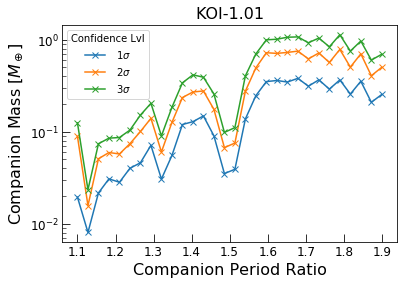

In [73]:
limits = np.array(limits)
for i in range(3):
    plt.semilogy(period_ratios,limits[:,i]/3e-6,'-x',label=" $%d\sigma$"%(i+1))
plt.legend(title="Confidence Lvl")
plt.ylabel("Companion Mass $[M_\oplus]$",fontsize=16)
plt.xlabel("Companion Period Ratio",fontsize=16)
plt.tick_params(labelsize=12,direction='in',size=8)
plt.tick_params(which="minor",direction='in',size=4)
plt.title("KOI-1.01",fontsize=16);

## Extend limit calculations to greater period ratio

In [61]:
period_ratios2 = np.linspace(2.1,3.9,30)
limits2 = pool.map(fn,P*period_ratios2)
limits2 = np.array(limits2)

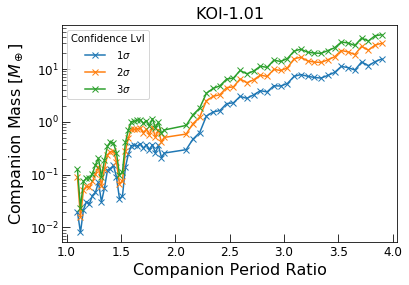

In [72]:
for i in range(3):
    plt.semilogy(np.append(period_ratios,period_ratios2),np.append(limits[:,i],limits2[:,i])/3e-6,'-x',label=" $%d\sigma$"%(i+1))
plt.legend(title="Confidence Lvl")
plt.ylabel("Companion Mass $[M_\oplus]$",fontsize=16)
plt.xlabel("Companion Period Ratio",fontsize=16)
plt.tick_params(labelsize=12,direction='in',size=8)
plt.tick_params(which="minor",direction='in',size=4)
plt.title("KOI-1.01",fontsize=16);